In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [252]:
df=pd.read_csv('AirPassengers.csv')
df=df.rename(columns={'#Passengers':'passengers','Month':'date'})
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)
df=df.drop(columns=['date'])
df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [253]:
# CHECK FOR NULL VALUES
df.isnull().sum()

passengers    0
dtype: int64

Text(0.5, 1.0, 'Average Monthly Number of Airline Passengers, 1949-1960')

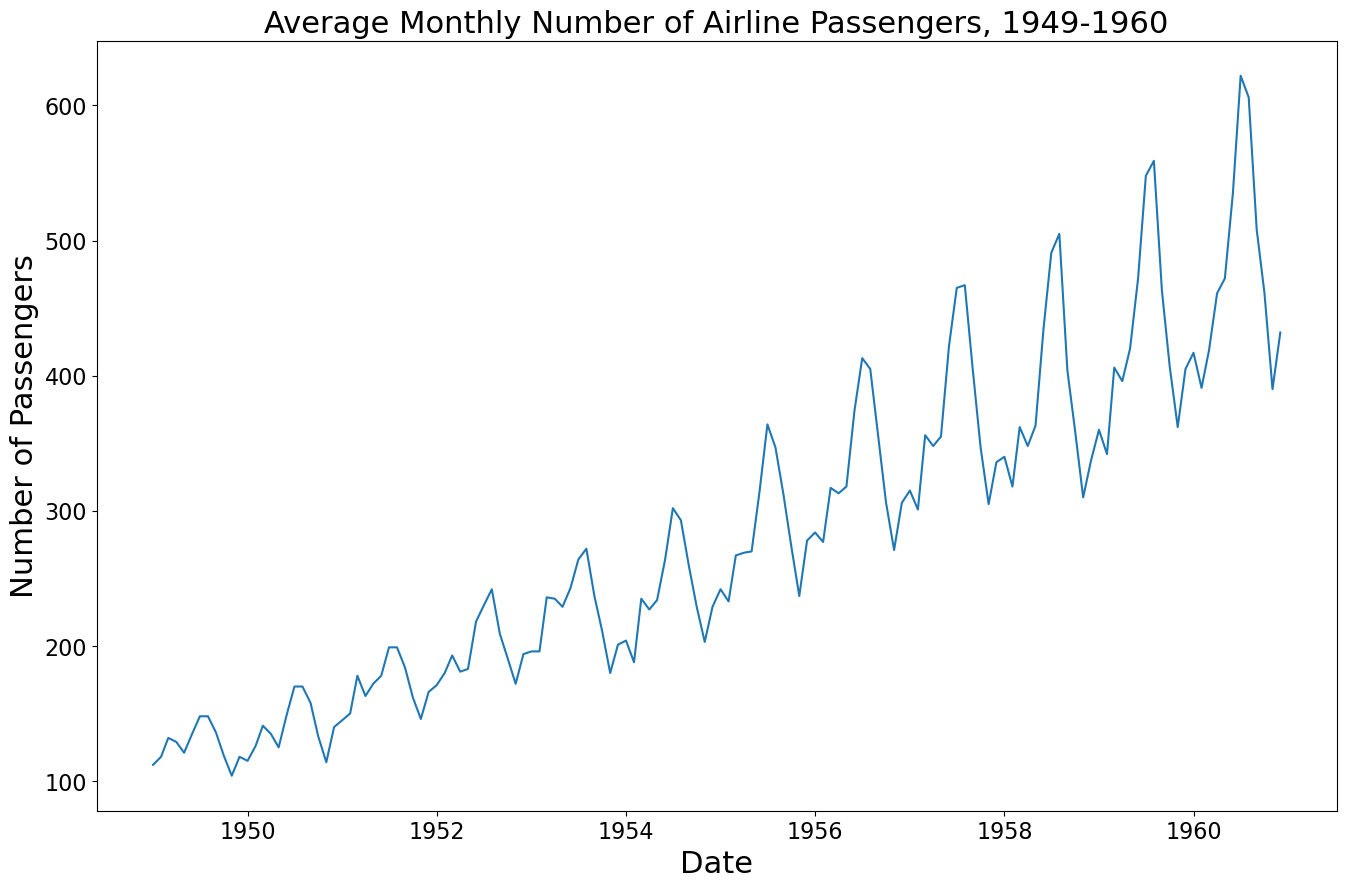

In [254]:
# Set figure size
plt.figure(figsize=(16,10))

# Create Line Plot
plt.plot(df['passengers'])

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Number of Passengers', fontsize=22)
plt.title('Average Monthly Number of Airline Passengers, 1949-1960', fontsize=22)
# plt.savefig('AverageMonthlyPassengers');

/var/folders/gr/drzxh4tx43x8k6w2tkbpkpxc0000gn/T/ipykernel_53202/3267250065.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['passengers'])


Text(0.5, 1.0, 'Distribution of Passengers')

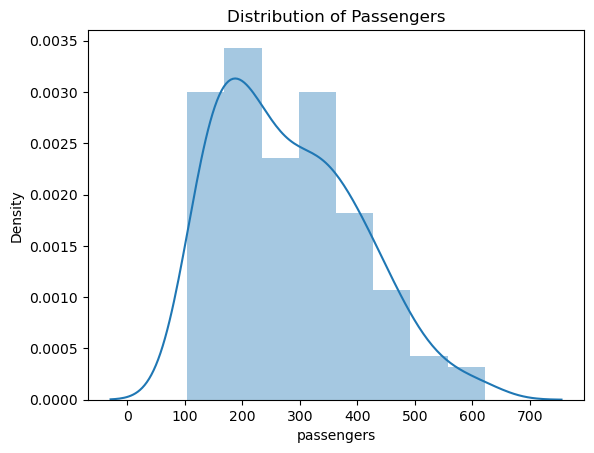

In [255]:
sns.distplot(df['passengers'])
plt.title('Distribution of Passengers')
# plt.savefig('DistributionPassengers.jpg')

<Figure size 640x480 with 0 Axes>

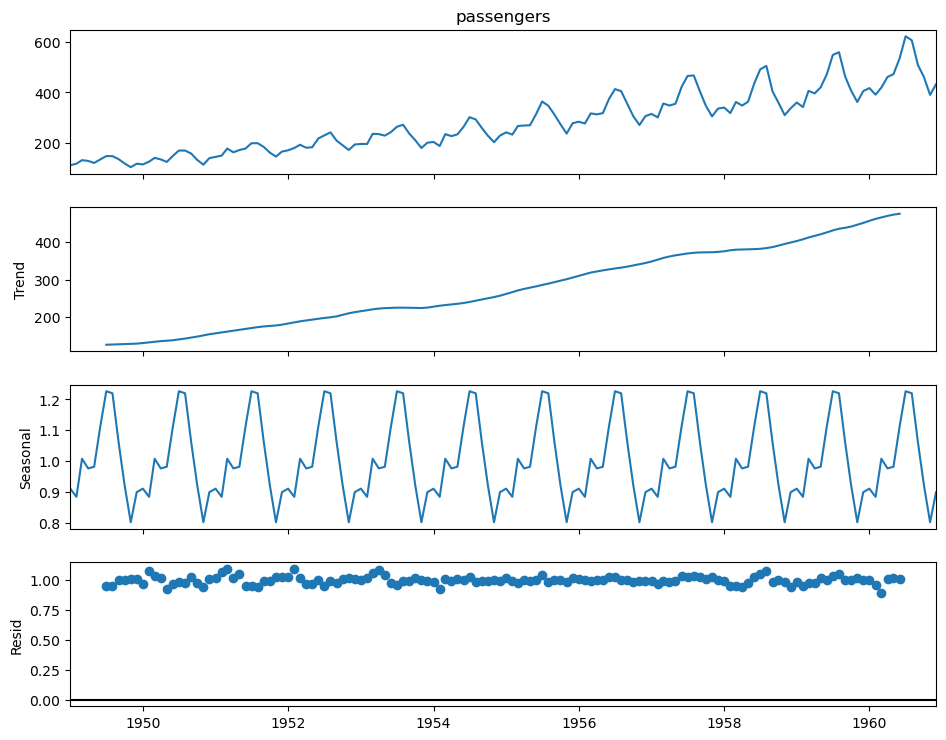

In [256]:
seasonal = seasonal_decompose(df.passengers,model='multiplicative')
fig = plt.figure()  
fig = seasonal.plot()  
fig.set_size_inches(10, 8)
# fig.savefig("ETS.jpg")

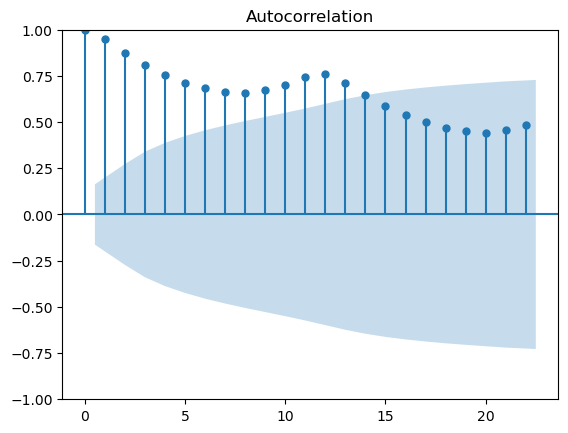

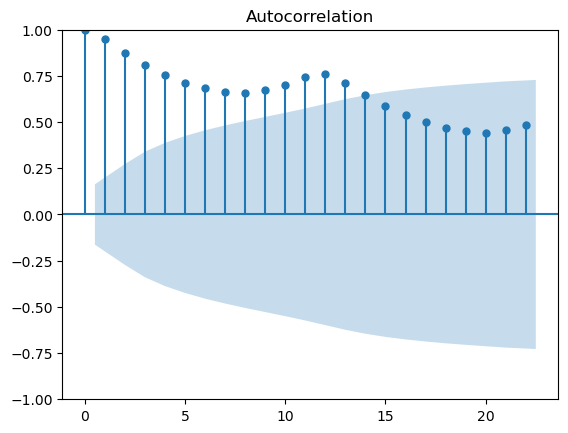

In [257]:
plot_acf(df['passengers'])
# plt.savefig('1_ACF.jpg');

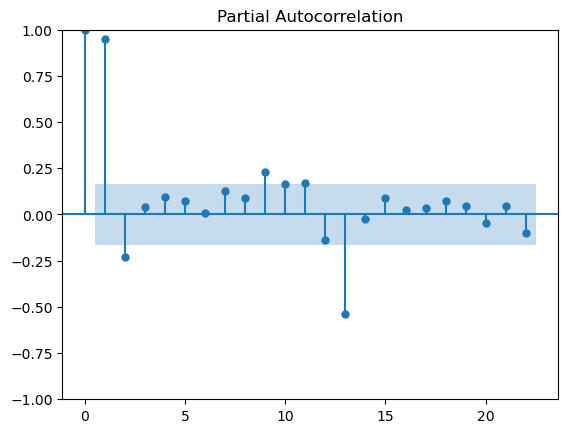

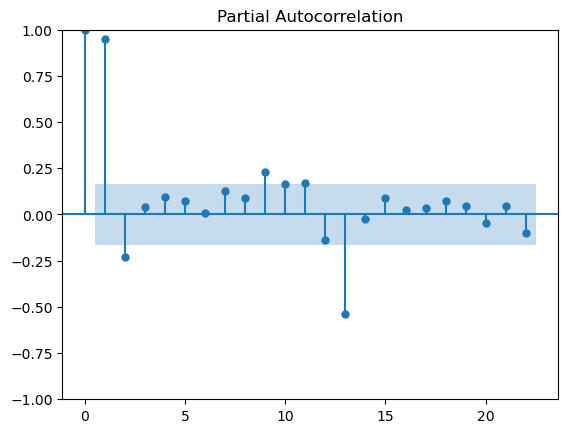

In [258]:
plot_pacf(df['passengers'])
# plt.savefig('1_PACF.jpg');

In [259]:
# Dickey-Fuller Test
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(df['passengers']))

Test Statistic    0.815369
p-value           0.991880
dtype: float64

In [260]:
interpret_dftest(adfuller(df['passengers'].diff().dropna()))

Test Statistic   -2.829267
p-value           0.054213
dtype: float64

In [261]:
interpret_dftest(adfuller(df['passengers'].diff().diff().dropna()))

Test Statistic   -1.638423e+01
p-value           2.732892e-29
dtype: float64

<Axes: xlabel='date'>

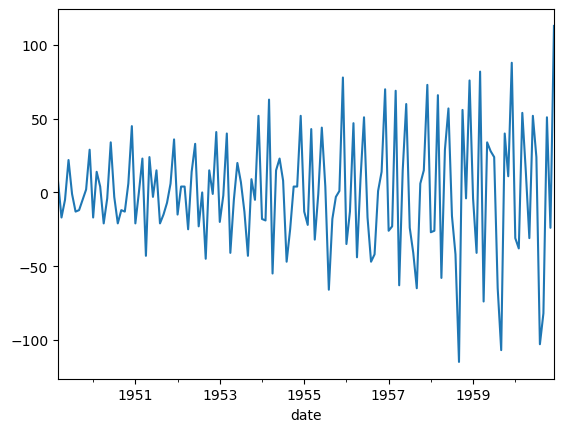

In [262]:
difference_df=df['passengers'].diff().diff().dropna()
difference_df.plot()
# plt.savefig('Difference.jpg')

Since 𝝰  > p-value, we can reject the null hypothesis and accept the alternative hypothesis that the data is stationary. We can now model our time series data by setting the difference hyperparameter to 2.

Let's look at the ACF/ PACF plots using the differenced data to visualize the lags that will likely be influencial when modeling the number of passengers.

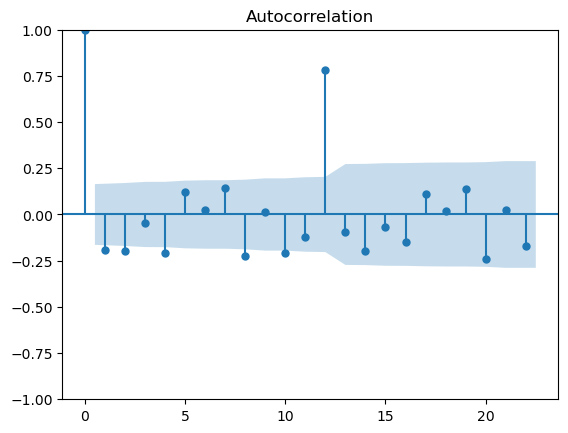

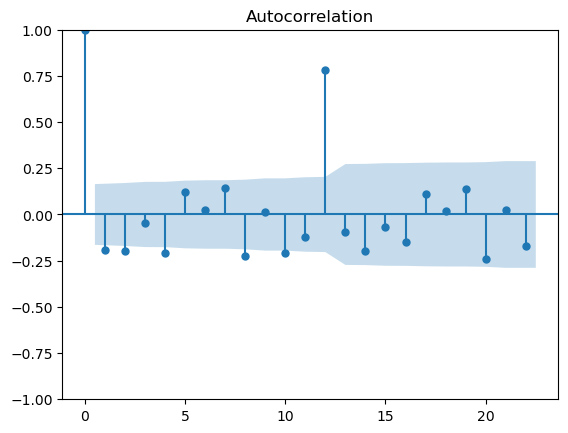

In [264]:
plot_acf(difference_df)
# plt.savefig('2_ACF.jpg');
# MA terms (q=2)

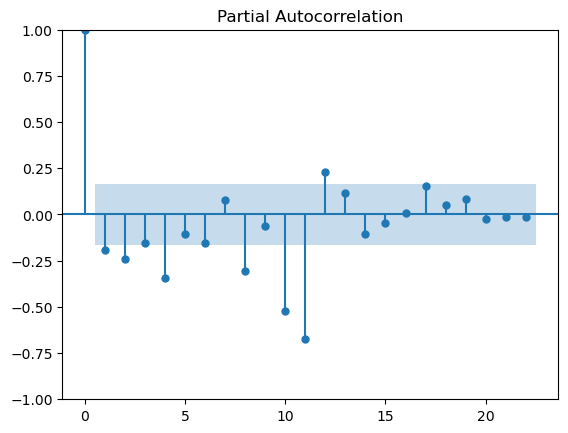

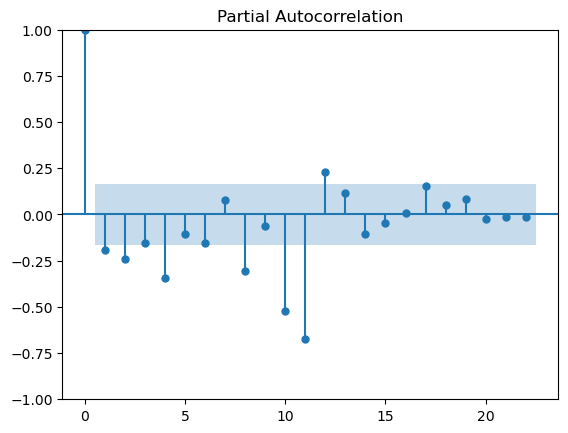

In [265]:
plot_pacf(difference_df)
# plt.savefig('2_PACF.jpg');
# AR terms(p= 0)

In [266]:
df.tail()

,passengers
date,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [267]:
train=df[:114]
test=df[-30:]

In [268]:
model = ARIMA(endog = train.astype(float).dropna(),
              order = (0,2,2))
arima = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [269]:
forecast = arima.forecast(len(test), alpha = 0.05)
stderr,conf_int=forecast, stderr

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [270]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  114
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -522.397
Date:                Wed, 29 Jan 2025   AIC                           1050.793
Time:                        15:24:36   BIC                           1058.949
Sample:                    01-01-1949   HQIC                          1054.102
                         - 06-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5747     20.086     -0.029      0.977     -39.943      38.794
ma.L2         -0.4252      8.610     -0.049      0.961     -17.301      16.451
sigma2       634.6030   1.28e+04      0.050      0.960   -2.45e+04    2.57e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.40   Prob(JB):                         0.20
Heteroskedasticity (H):               5.68   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [271]:
resid = test['passengers']-forecast

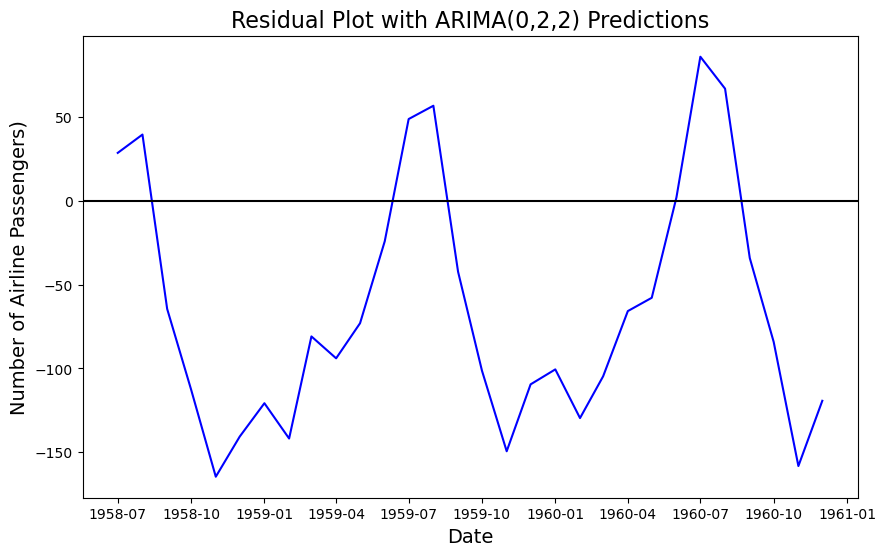

In [272]:
plt.figure(figsize=(10,6))
plt.plot(resid,color = 'blue') 
plt.ylabel('Number of Airline Passengers)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title(label = 'Residual Plot with ARIMA(0,2,2) Predictions', fontsize=16) 
plt.axhline(0, color = 'k', ls = '-')
plt.show();


Text(0.5, 1.0, 'Monthly Average Number of Airline Passengers with ARIMA(0, 2, 2) Predictions')

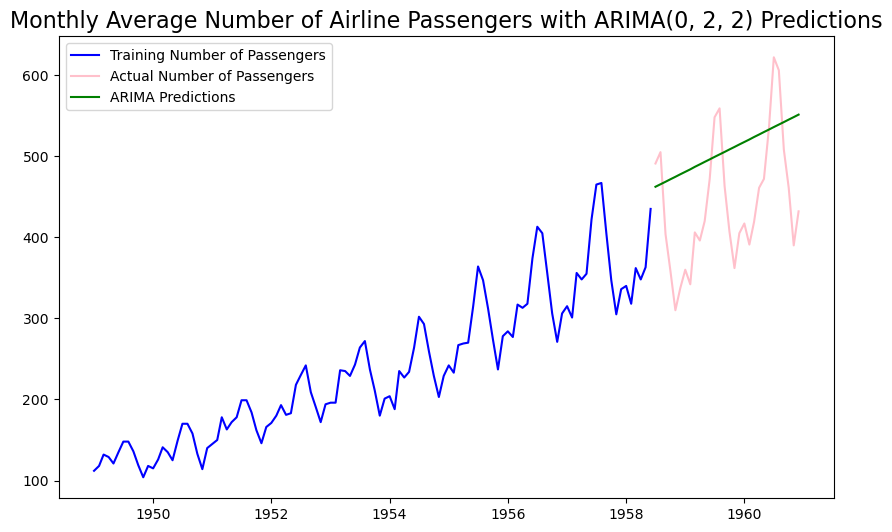

In [273]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, train['passengers'], color = 'blue', label = 'Training Number of Passengers')

# Plot testing data.
plt.plot(test.index, test['passengers'], color = 'pink', label = 'Actual Number of Passengers')

# Plot predicted test values.
plt.plot(test.index, forecast, color = 'green', label = 'ARIMA Predictions')

plt.legend(loc = 'upper left')
plt.title(label = 'Monthly Average Number of Airline Passengers with ARIMA(0, 2, 2) Predictions', fontsize=16)

# plt.savefig('FirstPredictions.jpg');

In [274]:
test['predicted_passengers'] = forecast
r2_score(test['passengers'], test['predicted_passengers'])

/var/folders/gr/drzxh4tx43x8k6w2tkbpkpxc0000gn/T/ipykernel_53202/3777915824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_passengers'] = forecast


-0.5537240545838293

# Using pmdarima for Time Series analysis

In [276]:
#We use the ‘Augmented Dickey-Fuller Test’ to check whether the data is stationary or not which is available in the ‘pmdarima’ package.
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df)
#From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

(0.01, False)

In [277]:
df.shape

(144, 1)

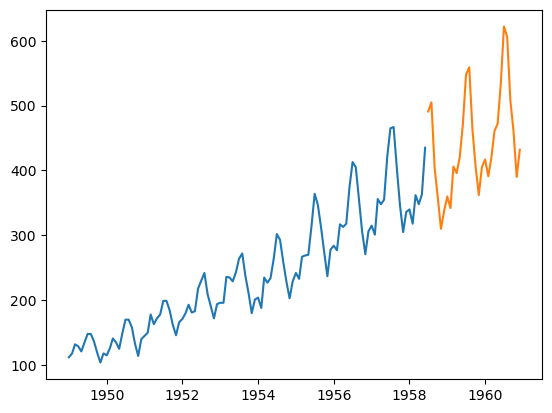

In [278]:
train=df[:114]
test=df[-30:]
plt.plot(train)
plt.plot(test)

In [279]:
model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=749.666, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=746.994, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=747.670, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=746.999, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=748.475, Time=0.17 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=748.774, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=747.301, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=748.578, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=748.460, Time=0.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=747.923, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=747.379, Time=0.08 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=749.897, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=748.975, Time=0.19 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]

In [280]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  114
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -370.497
Date:                            Wed, 29 Jan 2025   AIC                            746.994
Time:                                    15:24:39   BIC                            754.839
Sample:                                01-01-1949   HQIC                           750.170
                                     - 06-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1886      0.091     -2.073      0.038      -0.367      -0.010
ar.S.L12      -0.1449      0.083     -1.749      0.080      -0.307       0.017
sigma2        89.6411     13.913      6.443      0.000      62.372     116.910
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.89
Prob(Q):                              0.90   Prob(JB):                         0.24
Heteroskedasticity (H):               1.06   Skew:                             0.38
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [281]:
prediction = pd.DataFrame(model.predict(n_periods = 30),index=test.index)
prediction.columns = ['predicted_passengers']
prediction

,predicted_passengers
date,
1958-07-01,476.176329
1958-08-01,476.961678
1958-09-01,415.801515
1958-10-01,359.969314
1958-11-01,318.982257
1958-12-01,350.562278
1959-01-01,355.286877
1959-02-01,334.446337
1959-03-01,380.040576


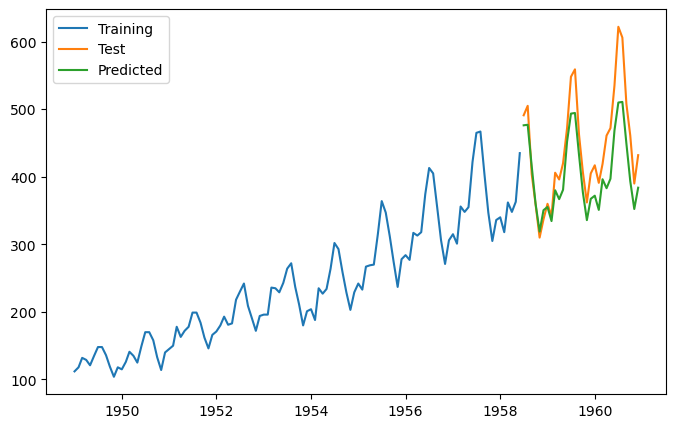

In [282]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('SecondPrection.jpg')
plt.show()

In [283]:
test['predicted_passengers'] = prediction
r2_score(test['passengers'], test['predicted_passengers'])


/var/folders/gr/drzxh4tx43x8k6w2tkbpkpxc0000gn/T/ipykernel_53202/2513786733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_passengers'] = prediction


0.6122080259142335